# Intrusion Classification

The task is to classify network traffic into 5 categories:

0 - DOS: denial-of-service, e.g. syn flood; (attack)

1 - normal (no attack)

2 - probing: surveillance and other probing, e.g., port scanning (attack)

3 - R2L: unauthorized access from a remote machine, e.g. guessing password (attack)

4 - U2R: unauthorized access to local superuser (root) privileges, e.g., various "buffer overflow'' attacks (attack)

Full description: [https://kaggle.com/c/intrusion-classification](https://kaggle.com/c/intrusion-classification)

## Preprocessing

### Including Necessary Libraries

In [1]:
# Experimenting
!apt install libomp-dev >/dev/null 2>&1
!python -m pip install --upgrade faiss-cpu faiss-gpu >/dev/null 2>&1
import faiss

In [2]:
# Required modules
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

### Initial Data Sanitisation

In [3]:
# Load data sets
data, exam = pd.read_csv("training.csv"), pd.read_csv("testing.csv")
rows = len(data)

# Merge for consistent encoding (split later)
data = data.append(exam, ignore_index=True)

data.drop("Id", axis=1, inplace=True)
data.head()

duration protocol_type  ... dst_host_srv_rerror_rate target
0         0           tcp  ...                      1.0    0.0
1         0          icmp  ...                      0.0    0.0
2         0           tcp  ...                      0.0    1.0
3         0           udp  ...                      0.0    1.0
4         0           tcp  ...                      0.0    1.0

[5 rows x 42 columns]

In [4]:
exam.head()

Id  duration  ... dst_host_rerror_rate dst_host_srv_rerror_rate
0   1     12275  ...                  0.0                      0.0
1   2      5065  ...                  0.0                      0.0
2   3         0  ...                  0.0                      0.0
3   4         0  ...                  0.0                      0.0
4   5         0  ...                  0.0                      0.0

[5 rows x 42 columns]

In [5]:
data.iloc[rows-5:].head(10)

duration protocol_type  ... dst_host_srv_rerror_rate target
449935         0           tcp  ...                      0.0    1.0
449936      1180           udp  ...                      0.0    1.0
449937         0           tcp  ...                      0.0    1.0
449938         0          icmp  ...                      0.0    0.0
449939         0          icmp  ...                      0.0    0.0
449940     12275           udp  ...                      0.0    NaN
449941      5065           udp  ...                      0.0    NaN
449942         0           udp  ...                      0.0    NaN
449943         0           tcp  ...                      0.0    NaN
449944         0           tcp  ...                      0.0    NaN

[10 rows x 42 columns]

In [6]:
# Eradicate null, infinite and identical values
data.fillna(0, inplace=True)
unique = data.nunique()
data.drop(unique[unique==1].index, axis=1, inplace=True)
#data.drop_duplicates(inplace=True)
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.astype({"target": int})
data.head()

duration protocol_type  ... dst_host_srv_rerror_rate target
0         0           tcp  ...                      1.0      0
1         0          icmp  ...                      0.0      0
2         0           tcp  ...                      0.0      1
3         0           udp  ...                      0.0      1
4         0           tcp  ...                      0.0      1

[5 rows x 41 columns]

This previous step helped clear an empty column with identical values.

In [7]:
# General statistics
data.describe()

duration     src_bytes  ...  dst_host_srv_rerror_rate         target
count  600000.000000  6.000000e+05  ...             600000.000000  600000.000000
mean      129.394583  9.298762e+03  ...                  0.134012       0.443503
std      1415.994191  2.686693e+06  ...                  0.337210       0.565398
min         0.000000  0.000000e+00  ...                  0.000000       0.000000
25%         0.000000  5.500000e+01  ...                  0.000000       0.000000
50%         0.000000  2.700000e+02  ...                  0.000000       0.000000
75%         0.000000  1.005000e+03  ...                  0.000000       1.000000
max     54451.000000  1.379964e+09  ...                  1.000000       4.000000

[8 rows x 38 columns]

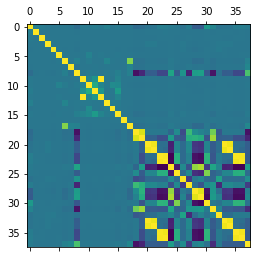

In [8]:
# Correlation graph
plt.matshow(data.corr())
plt.show()

### Normalising Values

In [9]:
# Normalisation (centring around zero)
scaler = StandardScaler()
numeric = data.select_dtypes(include="number").columns[1:-1]

for i in numeric:
  column = np.array(data[i])
  data[i] = scaler.fit_transform(column.reshape(len(column), 1))

data.head()

duration protocol_type  ... dst_host_srv_rerror_rate target
0         0           tcp  ...                 2.568102      0
1         0          icmp  ...                -0.397415      0
2         0           tcp  ...                -0.397415      1
3         0           udp  ...                -0.397415      1
4         0           tcp  ...                -0.397415      1

[5 rows x 41 columns]

In [25]:
# Save progress
data_ = data.copy()
#data = data_.copy()

### One-Hot Encoding

In [26]:
# One-hot encode strings into integers
# https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python

strs = "protocol_type service flag".split()
ints = pd.get_dummies(data[strs], columns=strs)

# This method was cumbersome
#encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
#ints = pd.DataFrame(encoder.fit_transform(data_[strs]))

data.drop(strs, axis=1, inplace=True)

for y, i in enumerate(ints):
  data.insert(y+1, i, ints[i])

data.head()

duration  protocol_type_icmp  ...  dst_host_srv_rerror_rate  target
0         0                   0  ...                  2.568102       0
1         0                   1  ...                 -0.397415       0
2         0                   0  ...                 -0.397415       1
3         0                   0  ...                 -0.397415       1
4         0                   0  ...                 -0.397415       1

[5 rows x 123 columns]

In [27]:
# Confirm no emtpy columns
all(len(set(data[x])) > 1 for x in data.columns)

True

In [28]:
# Split training and testing data
# https://stackoverflow.com/q/38835483#comment94270528_38835530

exam = data[rows:].copy()
exam = exam.iloc[:, :-1]
exam.reset_index(drop=True, inplace=True)

data = data[:rows].copy()
data.tail()

duration  protocol_type_icmp  ...  dst_host_srv_rerror_rate  target
449935         0                   0  ...                 -0.397415       1
449936      1180                   0  ...                 -0.397415       1
449937         0                   0  ...                 -0.397415       1
449938         0                   1  ...                 -0.397415       0
449939         0                   1  ...                 -0.397415       0

[5 rows x 123 columns]

In [29]:
# Confirm correct divide
exam.head()

duration  protocol_type_icmp  ...  dst_host_rerror_rate  dst_host_srv_rerror_rate
0     12275                   0  ...             -0.403872                 -0.397415
1      5065                   0  ...             -0.403872                 -0.397415
2         0                   0  ...             -0.403872                 -0.397415
3         0                   0  ...             -0.403872                 -0.397415
4         0                   0  ...             -0.403872                 -0.397415

[5 rows x 122 columns]

### Preparing for Training

In [30]:
# Features (X) and target (Y)
X = data.iloc[:, :-1]
Y = data.target

In [31]:
# Split data into training (75%) and testing (25%)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=0.75)
(train_X.shape, test_X.shape)

((337455, 122), (112485, 122))

## Part 1: Linear Support Vector Machine

### Training

In [32]:
# Create model - Support Vector Machine
fname = "svm.model"

if os.path.isfile(fname):
  # Restore saved model
  with open(fname, "rb") as f:
    SVM = pickle.load(f)
else:
  # Train model

  #SVM = SVC(kernel="linear", gamma="auto")
  # As per the docs:
  # Fit time scales at least quadratically with number of samples and may be impractical beyond 10,000s of samples.
  SVM = LinearSVC(random_state=0)
  SVM.fit(train_X, train_Y.ravel())

  # Save model
  with open(fname, "wb") as f:
    pickle.dump(SVM, f)

### Verifying

In [65]:
# Accuracy and F1 score function
def accuracy(model, tX, tY):
  guesses = model.predict(tX)
  accuracy = accuracy_score(tY, guesses)
  f1 = f1_score(tY, guesses, average="macro")
  print(f"Accuracy: {round(accuracy * 100, 2)}%")
  print(f"F1 score: {round(f1 * 100, 2)}%")

In [34]:
# Test model accuracy
guesses = accuracy(SVM, test_X, test_Y)

Accuracy: 99.39%
F1 score: 75.24%


### Predicting and Saving

In [55]:
# Apply model to test data
prediction = SVM.predict(exam)

In [56]:
# Save as CSV
with open("predicted-svm.csv", "w+") as f:
  f.write("Id,predicted\n")
  for i, value in enumerate(prediction, 1):
    f.write(f"{i},{value}\n")

## Part 2: Random Forest

### Training

In [40]:
# Create model - Random Forest
fname = "rf.model"

if os.path.isfile(fname):
  # Restore saved model
  with open(fname, "rb") as f:
    RF = pickle.load(f)
else:
  # Train model
  RF = RandomForestClassifier(random_state=0)
  RF.fit(train_X, train_Y.ravel())

  # Save model
  with open(fname, "wb") as f:
    pickle.dump(RF, f)

### Verifying

In [41]:
# Test model accuracy
guesses = accuracy(RF, test_X, test_Y)

Accuracy: 99.99%
F1 score: 97.73%


### Predicting and Saving

In [42]:
# Apply model to test data
prediction = RF.predict(exam)

In [39]:
# Save as CSV
with open("predicted-rf.csv", "w+") as f:
  f.write("Id,predicted\n")
  for i, value in enumerate(prediction, 1):
    f.write(f"{i},{value}\n")

## Part 3: K-nearest Neighbour

The first attempt will use Facebook's Faiss library.

### Training

In [43]:
# https://towardsdatascience.com/eaedc7a3a0c8
class FaissKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
    def fit(self, X, y):
        self.kmeans = faiss.Kmeans(d=X.shape[1], k=self.n_clusters, niter=self.max_iter, nredo=self.n_init)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]
    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]

In [63]:
# Create model - K-nearest Neighbour

# Train model
KNF = FaissKMeans(n_clusters=5)
KNF.fit(np.ascontiguousarray(train_X.to_numpy()), train_Y.ravel())

# ~Save model~
# Nope. Faiss index not serialisable (SwigPyObject)

### Verifying

In [66]:
# Test model accuracy
accuracy(KNF, np.ascontiguousarray(test_X.to_numpy()), test_Y)

Accuracy: 2.14%
F1 score: 1.24%


This is further proof that, due to the curse of dimensionality, KNN is a bad choice for high dimensional data because points seem so close to each other.

Let's repeat this experiment using SciKit.

### Training Again

In [51]:
# Create model - SciKit's K-nearest Neighbour
fname = "kn.model"

if os.path.isfile(fname):
  # Restore saved model
  with open(fname, "rb") as f:
    KN = pickle.load(f)
else:
  # Train model
  KN = KNeighborsClassifier(n_neighbors=5)
  KN.fit(train_X, train_Y.ravel())

  # Save model
  with open(fname, "wb") as f:
    pickle.dump(KN, f)

### Verifying Again

In [52]:
# Test model accuracy
guesses = accuracy(KN, test_X, test_Y)

Accuracy: 99.88%
F1 score: 79.13%


### Predicting and Saving

In [53]:
# Apply model to test data
prediction = KN.predict(exam)

In [54]:
# Save as CSV
with open("predicted-kn.csv", "w+") as f:
  f.write("Id,predicted\n")
  for i, value in enumerate(prediction, 1):
    f.write(f"{i},{value}\n")

## Part 4: Multi-layer Perceptron

### Training

In [72]:
# Create model - Random Forest
fname = "mlp.model"

if os.path.isfile(fname):
  # Restore saved model
  with open(fname, "rb") as f:
    MLP = pickle.load(f)
else:
  # Train model
  MLP = MLPClassifier(alpha=1, max_iter=100, random_state=0)
  MLP.fit(train_X, train_Y.ravel())

  # Save model
  with open(fname, "wb") as f:
    pickle.dump(MLP, f)

### Verifying

In [73]:
# Test model accuracy
accuracy(MLP, test_X, test_Y)

Accuracy: 99.89%
F1 score: 84.93%


### Predicting and Saving

In [74]:
# Apply model to test data
prediction = MLP.predict(exam)

In [79]:
# Save as CSV
with open("predicted-mlp.csv", "w+") as f:
  f.write("Id,predicted\n")
  for i, value in enumerate(prediction, 1):
    f.write(f"{i},{value}\n")

# Conclusion

Based on the aforementioned methods of data classification, namely Support Vector Machine (LSVM), Random Forest (RF), K-nearest Neighbour (KN), and Multi-layer Perceptron (MLP), it is clear based of the F1 and accuracy scores that RF and MLP are the most suitable classifier types for this kind of multi-dimensional data.

Network traffic is extremely delicate and volatile, and classifying it in higher dimensionality is difficult, as there are endless ways to go about it, and unseen traffic paves new paths for classification to go wrong.

As a suggestion implementation, I believe categorising traffic into "normal" (based on regular controlled observations) and "abnormal" in binary terms would more precisely detect abnormal traffic, as opposed to accidentally classifying a completely novel attack as normal traffic.

# Kaggle Scores

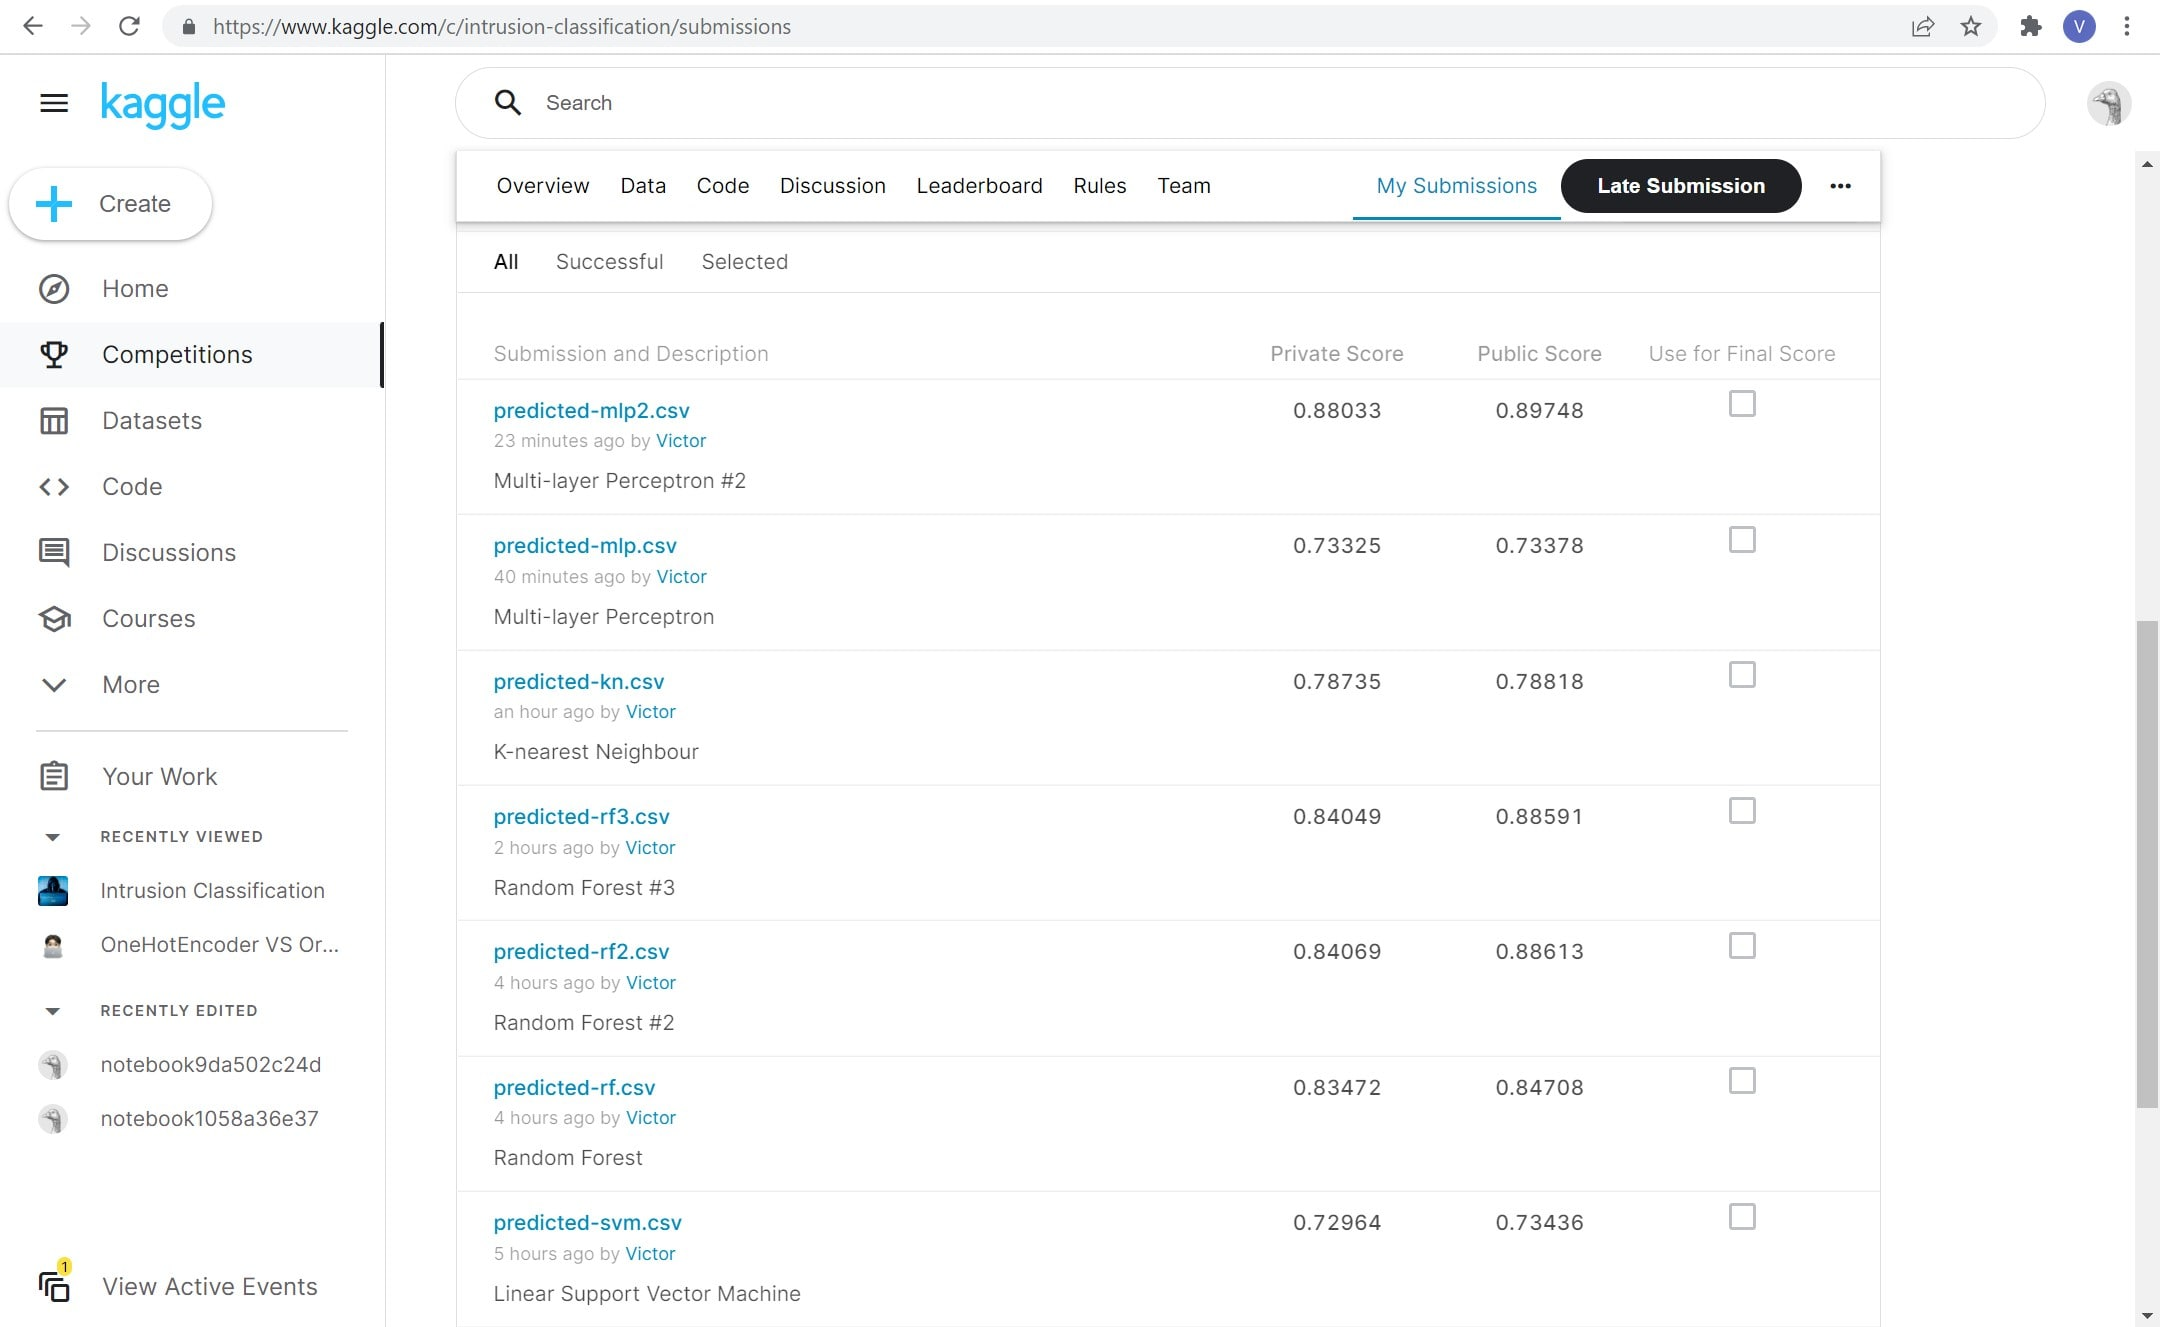